## HIQA data

I want to see if there is a seasonal component to Covid-19. Using data from HIQA - the Health Information Quality Authority of Ireland I wanted to plot European countries by lattitude and the week of their peak covid deaths.

The data comes from a table in this report from HIQA https://www.hiqa.ie/reports-and-publications/health-technology-assessment/analysis-excess-all-cause-mortality-ireland

In [21]:
import re
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from scipy.stats import spearmanr
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import math

def str_to_lat(s):
    '''Given a geographical coordinate in the format used in the report return a decimal latitude figure.'''
    match = re.match('([0-9]*)°([0-9]*)\'([NS])', s)
    sign = 1
    if match[3]=='S': sign=-1
    return sign*(int(match[1])+int(match[1])/60)

# test the function
str_to_lat('25°05\'S')

-25.416666666666668

In [22]:
# The HIQA data was saved as rates.txt

with open('rates.txt') as f:
    lines = f.readlines()

data = {}
for line in lines:
    val = line.split(' ')
    data[val[0]] = {'peak_week': int(val[-1].strip()), 'lat': None}

# latitude and longitude of all countries downloaded from web search
with open('lat_lon.txt') as f:
    lines = f.readlines()
    
for line in lines:
    val = line.split('\t')
    country = val[0]
    lat = str_to_lat(val[2])
    if country in data.keys():
        data[val[0]]['lat'] = lat

# A few of the data points in the HIQA reports had names that did not match the country names for which we had lats and longs.
# Manually put a couple of these in the data.
data['Northern']['lat'] = 54.6
data['England']['lat'] = 51.5

temp_dict = {}
for country in data.keys():
    if data[country]['lat'] is not None:
        temp_dict[country] = data[country]
data = temp_dict

Scatter plot of the week when covid deaths peaked against latitude of each country. There seems to be a reasonable correlation, albeit it from a limited dataset.

{'Greece': {'peak_week': 11, 'lat': 37.61666666666667},
 'Hungary': {'peak_week': 12, 'lat': 47.78333333333333},
 'Malta': {'peak_week': 12, 'lat': 35.583333333333336},
 'Denmark': {'peak_week': 14, 'lat': 55.916666666666664},
 'Austria': {'peak_week': 14, 'lat': 48.8},
 'Switzerland': {'peak_week': 14, 'lat': 46.766666666666666},
 'Portugal': {'peak_week': 14, 'lat': 38.63333333333333},
 'France': {'peak_week': 14, 'lat': 48.8},
 'Italy': {'peak_week': 14, 'lat': 41.68333333333333},
 'Netherlands': {'peak_week': 14, 'lat': 52.86666666666667},
 'Spain': {'peak_week': 14, 'lat': 40.666666666666664},
 'Germany': {'peak_week': 15, 'lat': 52.86666666666667},
 'Finland': {'peak_week': 15, 'lat': 61.0},
 'Luxembourg': {'peak_week': 15, 'lat': 49.81666666666667},
 'Ireland': {'peak_week': 15, 'lat': 53.88333333333333},
 'Northern': {'peak_week': 15, 'lat': 54.6},
 'Sweden': {'peak_week': 15, 'lat': 59.983333333333334},
 'Belgium': {'peak_week': 15, 'lat': 50.833333333333336},
 'England': {'pe

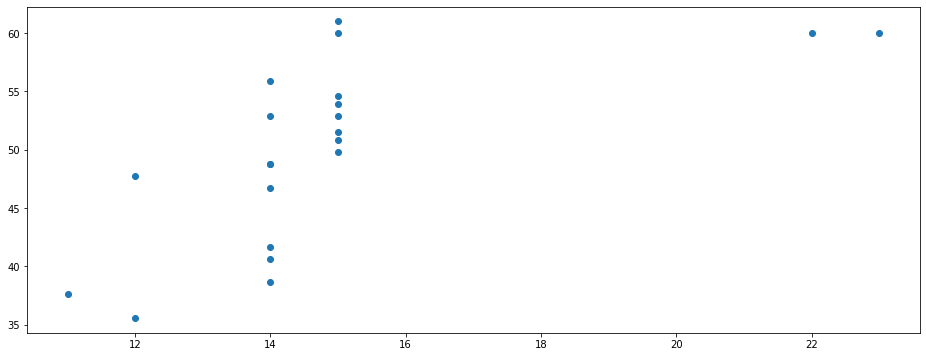

In [23]:
fig, ax = plt.subplots(1, figsize=(16,6))
x = [pair['peak_week'] for pair in data.values()]
y = [pair['lat'] for pair in data.values()]
_ = ax.scatter(x, y)

{k: v for k, v in sorted(data.items(), key=lambda item: item[1]['peak_week'])}

## Global data

Repeat the above analysis for global Covid data from WHO. Will also include population of countries from the World Bank as dot size in the scatter here.

### World bank population data

In [24]:
pop = pd.read_csv('API_SP.POP.TOTL_DS2_en_csv_v2_1308146.csv', skiprows=4)
pop = pop[['Country Name', '2019']].set_index('Country Name').to_dict()['2019']


def lookup_pop(country):
    '''Convert raw country population numbers into reasonable pixel sizes for scatter plot bubbles'''
    if country in pop.keys() and not math.isnan(pop[country]): 
        raw_pop = pop[country] 
        if raw_pop<1e6: return 5
        if raw_pop<1e7: return 20
        if raw_pop<1e8: return 40
        if raw_pop<1e9: return 80
        return 120
    else: 
        return 0

### WHO Covid data

Read in the data and plot time series for selected countries. Add more countries to the list to show comparisons.

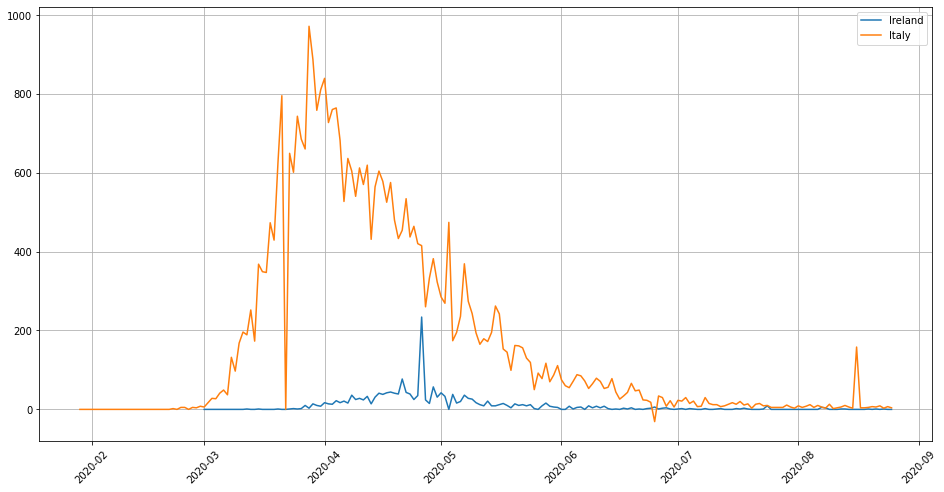

In [25]:
# This data was downloaded from this page https://covid19.who.int/table
register_matplotlib_converters()
who = pd.read_csv('WHO-COVID-19-global-data.csv', parse_dates=['Date_reported'], infer_datetime_format=True)
who.columns = [a.strip() for a in who.columns.values]
who.sort_values('Date_reported', inplace=True)
countries = ['Ireland', 'Italy']
fig, ax = plt.subplots(1, figsize=(16,8))
for country in countries:
    dat = who[who['Country']==country]
    ax.plot(dat['Date_reported'], dat['New_deaths'], label=country)
    
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

new_deaths_by_country = {}
for country in who['Country'].unique():
    dat = who[who['Country']==country]
    row = dat.loc[dat['New_deaths'].idxmax()]
    new_deaths_by_country[country] = {'peak_date': row['Date_reported'], 'lat': None}

In [26]:
with open('lat_lon.txt') as f:
    lines = f.readlines()
    
for line in lines:
    val = line.split('\t')
    country = val[0]
    lat = str_to_lat(val[2])
    if country in new_deaths_by_country.keys():
        new_deaths_by_country[val[0]]['lat'] = lat

temp_dict = {}
for country in new_deaths_by_country.keys():
    if new_deaths_by_country[country]['lat'] is not None:
        temp_dict[country] = new_deaths_by_country[country]
new_deaths_by_country = temp_dict

x = [pair['peak_date'] for pair in new_deaths_by_country.values()]
y = [pair['lat'] for pair in new_deaths_by_country.values()]
countries = [country[0] for country in new_deaths_by_country.items()]



population_per_country = [lookup_pop(country) for country in countries]

fig = go.Figure(data = go.Scatter(x=x, y=y, mode='markers', text=countries, marker_size=population_per_country))
fig.show()

In [31]:
#![plot](newplot.png)

In summary: While there does appear to be a downward trend in the data it is not a very strong correlation in this basic analysis. 